# Load data

In [1]:
import os
import pandas as pd

import pickle
from collections import Counter
from tqdm import tqdm
import numpy as np
import random

import seaborn as sns
from _00_text_utils import title_process, process_quoting, comment_process, selftext_process

import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid", palette="deep")

In [2]:
df = pd.read_csv(f'{os.getcwd()}/data/data_active_situationExt.tsv', sep='\t')

further process df

In [3]:
invalid_indices = []
for idx, row in df.iterrows():
    if row['title'] != row['title']:
        invalid_indices.append(idx)
    elif row['title'].strip() in ['[removed]', '[deleted by user]', '[deleted]', '[removed by user]']:
        invalid_indices.append(idx)
    if row['selftext'] != row['selftext']:
        invalid_indices.append(idx)
    elif row['selftext'].strip() in ['[removed]', '[deleted by user]', '[deleted]', '[removed by user]']:
        invalid_indices.append(idx)
    if row['comment'] != row['comment']:
        invalid_indices.append(idx)
print(len(invalid_indices))
df.drop(invalid_indices, inplace=True)
df.reset_index(drop=True, inplace=True)

1


In [4]:
df['title'] = df['title'].apply(lambda x:title_process(x))
df['selftext'] = df['selftext'].apply(lambda x:selftext_process(x))
df['comment'] = df['comment'].apply(lambda x:comment_process(x))
df['comment'] = df['comment'].apply(lambda x:process_quoting(x))

In [12]:
df.to_csv(f'{os.getcwd()}/data/data_active_situationExt.tsv', sep='\t', index=False)

In [15]:
df.head()

,subID,title,selftext,commAuthor,comment,judgment
0,h0ghw3,asking my boyfriend to stop wearing suits outs...,"I know this sounds weird, but here goes:\n\nI ...",WinchesterFan1980,"This is a daughter problem, not a suit problem...",0
1,h0jty3,telling my male friend that he’s shit at sex,"One of my (24F) male friends, I’ll call Jack (...",pluckyminna,It's fucking inappropriate for him to bring up...,0
2,h0n98t,not eating my wife’s spicy cooking,My wife insists on cooking dinner every night ...,WeaverFan420,My wife and I are the opposite - I love spicy ...,1
3,h0lqgh,telling my best friend of 15 years that I don'...,"Friend got engaged to a guy over xmas, and I'm...",JenningsWigService,except the fiancé You will have to stop inviti...,1
4,h0nudu,I skip my childhood BEST friend's wedding,My best friend growing up is getting married t...,JeepersCreepers74,Doesn't sound like you are still close enough ...,1


## Determine which authors to fine-tune for baseline

In [5]:
author_cnt = Counter()
author_cnt.update(df.commAuthor.tolist())
author_cnt = sorted(author_cnt.items(), key=lambda x:x[1], reverse=True)

In [6]:
j, thr_list = 0, [2000, 1000, 500, 200, 100]
for i, elem in enumerate(author_cnt):
    if elem[1] <= thr_list[j]:
        print(f"{i} authors commented more than {thr_list[j]}")
        j += 1
    if j >= len(thr_list):
        break

8 authors commented more than 2000
41 authors commented more than 1000
224 authors commented more than 500
1475 authors commented more than 200
3826 authors commented more than 100


# Create data splits for each redditor
- Create a train-test split
- For each author in train
    - Apply k-fold validation (k=5)
- Save all *author_train_k.npy*, *author_valid_k.npy*, and *author_test.npy*
- Check label distribution!

In [16]:
k = 5

In [7]:
AUTHORS = [elem[0] for elem in author_cnt[:224]]

In [18]:
def df_to_npy(data, author, fold=0, split='test'):
    result_list = []
    for idx, row in data.iterrows():
        result_list.append({'subID':row['subID'], 'title':row['title'], 'selftext':row['selftext'], \
                            'comment':row['comment'], 'judgment':row['judgment']})
    if split == 'test':
        filepath = f"{os.getcwd()}/data/bySituation/{author}_test.npy"
    elif split == 'testHard':
        filepath = f"{os.getcwd()}/data/bySituation/{author}_testHard.npy"
    else:
        filepath = f"{os.getcwd()}/data/bySituation/{author}_{split}_{fold}.npy"
        
    random.shuffle(result_list)
    np.save(filepath, result_list)
    return

In [19]:
for _author in tqdm(AUTHORS):
    minidf = df[df['commAuthor']==_author]
    minidf_trainvalid = minidf.sample(frac=0.7, replace=False, random_state=2024)
    minidf_test = minidf[~minidf.index.isin(minidf_trainvalid.index)]

    df_to_npy(minidf_test, _author)

    for i in range(k):
        minidf_train = minidf_trainvalid.sample(frac=0.858, replace=False, random_state=2024+i)
        minidf_valid = minidf_trainvalid[~minidf_trainvalid.index.isin(minidf_train.index)]
        df_to_npy(minidf_train, _author, i, "train")
        df_to_npy(minidf_valid, _author, i, "valid")

100%|█████████████████████████████████████████████████████████████████████████| 224/224 [00:21<00:00, 10.52it/s]


### Create hardTest.npy

In [20]:
with open(f"{os.getcwd()}/data/subID_to_votes.pkl", "rb") as f:
    subID_to_votes = pickle.load(f)

In [21]:
controversial_ = []
for idx, row in df.iterrows():
    judgments = subID_to_votes[row['subID']]
    acceptable_portion = sum(judgments)/len(judgments)
    if acceptable_portion < 0.3 or acceptable_portion > 0.7:
        controversial_.append(0)
    else:
        controversial_.append(1)

In [22]:
df['controversial'] = controversial_

In [23]:
for _author in tqdm(AUTHORS):
    minidf = df[df['commAuthor']==_author]
    minidf_trainvalid = minidf.sample(frac=0.7, replace=False, random_state=2024)
    minidf_test = minidf[~minidf.index.isin(minidf_trainvalid.index)]
    minidf_test_hard = minidf_test[minidf_test['controversial']==1]

    df_to_npy(minidf_test_hard, _author, split="testHard")

100%|█████████████████████████████████████████████████████████████████████████| 224/224 [00:07<00:00, 31.13it/s]


In [27]:
df.head()

,subID,title,selftext,commAuthor,comment,judgment,controversial
0,h0ghw3,asking my boyfriend to stop wearing suits outs...,"I know this sounds weird, but here goes:\n\nI ...",WinchesterFan1980,"This is a daughter problem, not a suit problem...",0,0
1,h0jty3,telling my male friend that he’s shit at sex,"One of my (24F) male friends, I’ll call Jack (...",pluckyminna,It's fucking inappropriate for him to bring up...,0,0
2,h0n98t,not eating my wife’s spicy cooking,My wife insists on cooking dinner every night ...,WeaverFan420,My wife and I are the opposite - I love spicy ...,1,0
3,h0lqgh,telling my best friend of 15 years that I don'...,"Friend got engaged to a guy over xmas, and I'm...",JenningsWigService,except the fiancé You will have to stop inviti...,1,0
4,h0nudu,I skip my childhood BEST friend's wedding,My best friend growing up is getting married t...,JeepersCreepers74,Doesn't sound like you are still close enough ...,1,0


In [38]:
len(list(set(df.subID.tolist())))

217263

### testHard marker file

In [29]:
author_to_testHardIdx = {_author:[] for _author in AUTHORS}
for _author in tqdm(AUTHORS):
    minidf = df[df['commAuthor']==_author]
    minidf_trainvalid = minidf.sample(frac=0.7, replace=False, random_state=2024)
    minidf_test = minidf[~minidf.index.isin(minidf_trainvalid.index)]
    author_to_testHardIdx[_author] = minidf_test['controversial'].tolist()

100%|█████████████████████████████████████████████████████████████████████████| 224/224 [00:07<00:00, 31.48it/s]


In [30]:
with open(f"{os.getcwd()}/data/author_to_controversialIndex_bySituation.pkl", "wb") as f:
    pickle.dump(author_to_testHardIdx, f)

### visualize author's judgment distributions

In [8]:
minidf = df[df['commAuthor'].isin(AUTHORS)]
author_to_judgments = {_author:[] for _author in AUTHORS}
for idx, row in minidf.iterrows():
    author_to_judgments[row['commAuthor']].append(row['judgment'])

author_to_judgment_dist = {_author:sum(author_to_judgments[_author])/len(author_to_judgments[_author]) for _author in AUTHORS}

In [9]:
author_to_judgment_dist_tup = author_to_judgment_dist.items()
df_viz = pd.DataFrame(data={'authors':[elem[0] for elem in author_to_judgment_dist_tup], 'dists':[elem[1] for elem in author_to_judgment_dist_tup]})

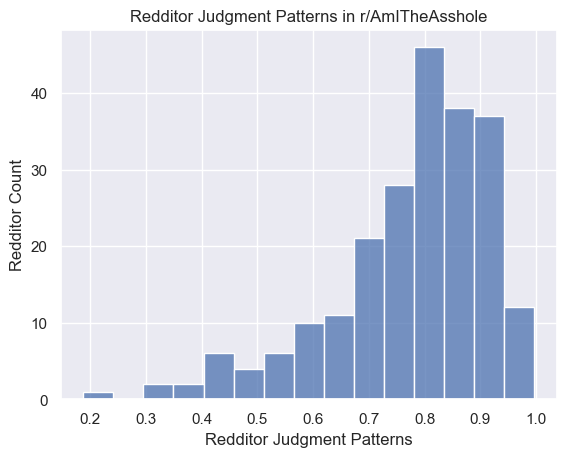

<Axes: title={'center': 'Redditor Judgment Patterns in r/AmITheAsshole'}, xlabel='Redditor Judgment Patterns', ylabel='Redditor Count'>

In [10]:
g = sns.histplot(data=df_viz, x="dists")
plt.title('Redditor Judgment Patterns in r/AmITheAsshole')
plt.xlabel('Redditor Judgment Patterns')
plt.ylabel('Redditor Count')
# plt.legend(title='Embedding Set')
# plt.grid(True)
plt.show()
g

In [11]:
g.figure.savefig(f'{os.getcwd()}/diagram/all_judgment_patterns.png', bbox_inches='tight')

In [32]:
author_to_judgment_dist_s = sorted(author_to_judgment_dist.items(), key=lambda x:x[1])